# Phishing Feature Selection — **InfoGain Only** (Top-10)

Tujuan: Pemilihan fitur **semua** pakai **Information Gain (mutual_info_classif)**. Random Forest **hanya** sebagai *klasifier* + *explainability* (SHAP):
1) **Eksperimen A**: InfoGain pada **fitur mentah** (tanpa diskretisasi)
2) **Eksperimen B**: InfoGain pada **fitur yang sudah didiskretisasi**

> Hasilnya dibandingkan (akurasinya dan overlap fitur Top-10).

In [1]:

# === Import ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import KBinsDiscretizer
import shap

shap.initjs()
print("Libraries loaded.")


c:\Users\THINKBOOK\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries loaded.


In [3]:
# from google.colab import files <-- Beri pagar agar tidak jalan
# uploaded = files.upload()      <-- Beri pagar agar tidak jalan

# Ganti dengan alamat file di folder laptopmu (sesuai gambar foldermu tadi)
df_raw = pd.read_csv('data/dataset phising raw.csv')

In [5]:
# === Basic Cleaning ===
df_raw = pd.read_csv('data/dataset phising raw.csv')
df = df_raw.copy()

# Pastikan ada kolom status (legitimate/phishing)
if "status" not in df.columns:
    if "label" in df.columns:
        df = df.rename(columns={"label":"status"})
    else:
        raise KeyError("Expected a 'status' or 'label' column.")

# Drop URL jika ada
if "url" in df.columns:
    df = df.drop(columns=["url"])

# Keep only legitimate & phishing
df = df[df["status"].isin(["legitimate", "phishing"])].reset_index(drop=True)

# y: phishing=1, legitimate=0
y = (df["status"]=="phishing").astype(int)

# X: only numeric
X = df.drop(columns=["status"]).select_dtypes(include=[np.number]).copy()

print("Shape X:", X.shape, "| y:", y.shape)
print("Class balance:")
print(y.value_counts())
display(X.head(3))


Shape X: (11430, 87) | y: (11430,)
Class balance:
status
0    5715
1    5715
Name: count, dtype: int64


,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
0,37,19,0,3,0,0,0,0,0,0,...,0,0,1,0,45,-1,0,1,1,4
1,77,23,1,1,0,0,0,0,0,0,...,0,1,0,0,77,5767,0,0,1,2
2,126,50,1,4,1,0,1,2,0,3,...,0,1,0,0,14,4004,5828815,0,1,0


## Eksperimen A — InfoGain pada fitur **tanpa diskretisasi**

Top-10 fitur (InfoGain, RAW):


,MI
google_index,0.307962
web_traffic,0.295119
domain_age,0.267603
ratio_extHyperlinks,0.244199
ratio_intHyperlinks,0.243404
nb_hyperlinks,0.237723
page_rank,0.215672
safe_anchor,0.191194
domain_registration_length,0.144498
links_in_tags,0.118966


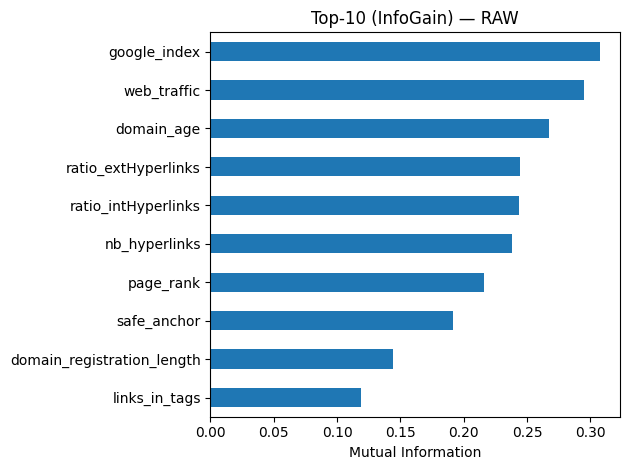

In [6]:
# === Train/Test Split ===
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === InfoGain (mutual_info_classif) ===
# Untuk data mentah (banyaknya numerik kontinu), gunakan discrete_features=False (default).
mi_A = mutual_info_classif(X_train_A, y_train_A, random_state=42)
mi_A_series = pd.Series(mi_A, index=X_train_A.columns).sort_values(ascending=False)

print("Top-10 fitur (InfoGain, RAW):")
display(mi_A_series.head(10).to_frame("MI"))

plt.figure()
mi_A_series.head(10).iloc[::-1].plot(kind="barh")
plt.title("Top-10 (InfoGain) — RAW")
plt.xlabel("Mutual Information")
plt.tight_layout()
plt.show()

topk_A = mi_A_series.head(10).index.tolist()

In [7]:
# === Random Forest as classifier (ONLY) ===
rf_A = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_A.fit(X_train_A[topk_A], y_train_A)
pred_A = rf_A.predict(X_test_A[topk_A])

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
acc_A = accuracy_score(y_test_A, pred_A)
print(f"Akurasi A (InfoGain RAW, Top-10): {acc_A:.4f}")
print("\nClassification Report — A")
print(classification_report(y_test_A, pred_A, digits=4))
print("Confusion Matrix — A")
print(confusion_matrix(y_test_A, pred_A))

Akurasi A (InfoGain RAW, Top-10): 0.9440

Classification Report — A
              precision    recall  f1-score   support

           0     0.9471    0.9405    0.9438      1143
           1     0.9409    0.9475    0.9442      1143

    accuracy                         0.9440      2286
   macro avg     0.9440    0.9440    0.9440      2286
weighted avg     0.9440    0.9440    0.9440      2286

Confusion Matrix — A
[[1075   68]
 [  60 1083]]


<Figure size 640x480 with 0 Axes>

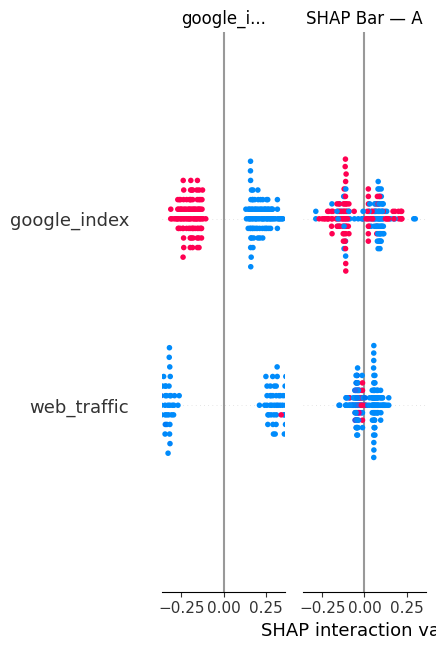

In [20]:
# 1) pastikan urutan kolom PERSIS sama seperti saat training (topk_A)
X_sample_A = X_test_A[topk_A].sample(min(200, len(X_test_A)), random_state=42)

# 2) pakai numpy agar bentuk matriks pasti cocok
X_sample_A_np = X_sample_A.to_numpy()
feature_names_A = list(topk_A)  # dipakai untuk label fitur di plot

# 3) hitung SHAP
explainer_A = shap.TreeExplainer(rf_A)
shap_vals_A = explainer_A.shap_values(X_sample_A_np)

# 4) pilih kelas "phishing" (label 1) secara dinamis
if isinstance(shap_vals_A, list):
    class_idx_A = int(np.where(rf_A.classes_ == 1)[0][0])  # cari index kelas 1
    shap_vals_A_plot = shap_vals_A[class_idx_A]
else:
    shap_vals_A_plot = shap_vals_A  # sudah 2D (n_samples, n_features)

# 5) plot bar (global importance versi SHAP)
plt.figure()
shap.summary_plot(shap_vals_A_plot, X_sample_A_np, feature_names=feature_names_A, plot_type="bar", show=False)
plt.title("SHAP Bar — A")
plt.tight_layout()
plt.show()


## Eksperimen B — InfoGain setelah **diskretisasi** (KBins)

In [21]:
# === Discretization ===
# Deteksi fitur kontinu ringan (nunique>10) untuk didiskretisasi
cont_cols = [c for c in X.columns if X[c].nunique() > 10]

X_disc = X.copy()
if len(cont_cols) > 0:
    kbd = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform")
    Xb = kbd.fit_transform(X_disc[cont_cols])
    import pandas as pd
    Xb = pd.DataFrame(Xb, columns=[f"disc_{c}" for c in cont_cols], index=X_disc.index)
    X_disc = X_disc.drop(columns=cont_cols)
    X_disc = pd.concat([X_disc, Xb], axis=1)
else:
    print("No continuous columns to discretize.")

print("Shape X_disc:", X_disc.shape)
display(X_disc.head(3))


Shape X_disc: (11430, 87)


,ip,nb_at,nb_qm,nb_or,nb_tilde,nb_star,nb_colon,nb_comma,nb_dollar,nb_space,...,disc_ratio_extRedirection,disc_ratio_extErrors,disc_links_in_tags,disc_ratio_intMedia,disc_ratio_extMedia,disc_safe_anchor,disc_domain_registration_length,disc_domain_age,disc_web_traffic,disc_page_rank
0,0,0,0,0,0,0,1,0,0,0,...,2.0,2.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0
1,1,0,0,0,0,0,1,0,0,0,...,0.0,0.0,4.0,4.0,1.0,4.0,0.0,2.0,0.0,1.0
2,1,0,1,0,0,0,1,0,0,0,...,0.0,0.0,4.0,0.0,0.0,4.0,0.0,1.0,2.0,0.0


Top-10 fitur (InfoGain, DISCRETIZED):


,MI
google_index,0.305210
disc_page_rank,0.188704
nb_www,0.108195
disc_safe_anchor,0.085516
phish_hints,0.078958
disc_ratio_intHyperlinks,0.067780
domain_in_title,0.062862
ip,0.057499
disc_links_in_tags,0.057274
disc_ratio_digits_url,0.057134


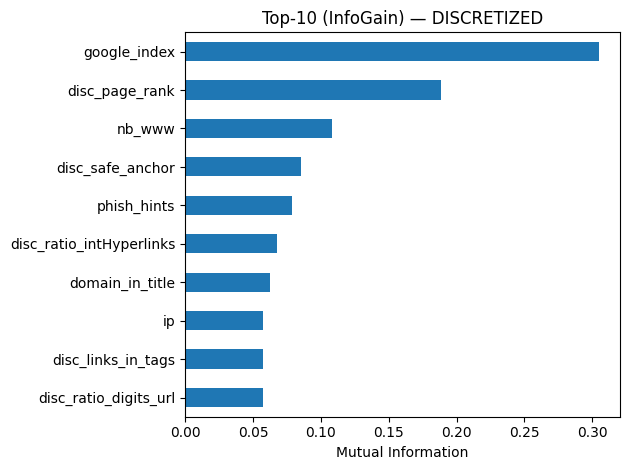

In [22]:
# === Train/Test Split for B ===
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    X_disc, y, test_size=0.2, random_state=42, stratify=y
)

# === InfoGain on discretized features ===
mi_B = mutual_info_classif(X_train_B, y_train_B, discrete_features=True, random_state=42)
mi_B_series = pd.Series(mi_B, index=X_train_B.columns).sort_values(ascending=False)

print("Top-10 fitur (InfoGain, DISCRETIZED):")
display(mi_B_series.head(10).to_frame("MI"))

plt.figure()
mi_B_series.head(10).iloc[::-1].plot(kind="barh")
plt.title("Top-10 (InfoGain) — DISCRETIZED")
plt.xlabel("Mutual Information")
plt.tight_layout()
plt.show()

topk_B = mi_B_series.head(10).index.tolist()

In [19]:
# === Random Forest as classifier (ONLY) ===
rf_B = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_B.fit(X_train_B[topk_B], y_train_B)
pred_B = rf_B.predict(X_test_B[topk_B])

acc_B = accuracy_score(y_test_B, pred_B)
print(f"Akurasi B (InfoGain + Discretized, Top-10): {acc_B:.4f}")
print("\nClassification Report — B")
print(classification_report(y_test_B, pred_B, digits=4))
print("Confusion Matrix — B")
print(confusion_matrix(y_test_B, pred_B))

Akurasi B (InfoGain + Discretized, Top-10): 0.9265

Classification Report — B
              precision    recall  f1-score   support

           0     0.9265    0.9265    0.9265      1143
           1     0.9265    0.9265    0.9265      1143

    accuracy                         0.9265      2286
   macro avg     0.9265    0.9265    0.9265      2286
weighted avg     0.9265    0.9265    0.9265      2286

Confusion Matrix — B
[[1059   84]
 [  84 1059]]


<Figure size 640x480 with 0 Axes>

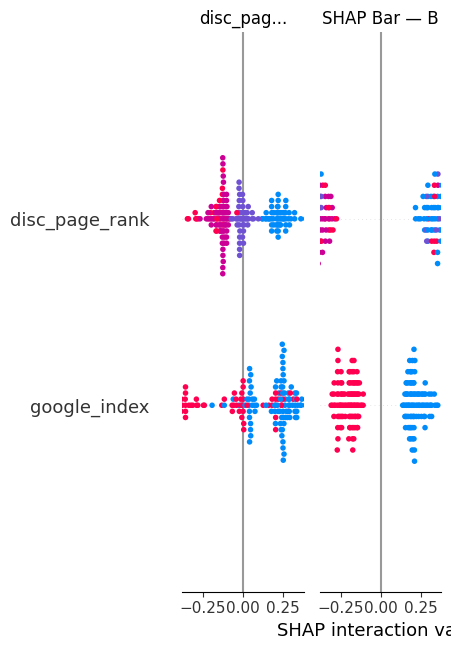

In [23]:
# 1) pastikan urutan kolom persis sama seperti saat training (topk_B)
X_sample_B = X_test_B[topk_B].sample(min(200, len(X_test_B)), random_state=42)

# 2) pakai numpy agar shape pasti cocok
X_sample_B_np = X_sample_B.to_numpy()
feature_names_B = list(topk_B)

# 3) hitung SHAP
explainer_B = shap.TreeExplainer(rf_B)
shap_vals_B = explainer_B.shap_values(X_sample_B_np)

# 4) pilih index kelas "phishing" (label = 1) secara dinamis
if isinstance(shap_vals_B, list):
    class_idx_B = int(np.where(rf_B.classes_ == 1)[0][0])
    shap_vals_B_plot = shap_vals_B[class_idx_B]
else:
    shap_vals_B_plot = shap_vals_B  # sudah 2D (n_samples, n_features)

# 5) bar plot (global importance)
plt.figure()
shap.summary_plot(shap_vals_B_plot, X_sample_B_np, feature_names=feature_names_B, plot_type="bar", show=False)
plt.title("SHAP Bar — B")
plt.tight_layout()
plt.show()


## Ringkasan, Overlap, dan Catatan

In [24]:
# === Summary Table ===
import pandas as pd
summary = pd.DataFrame([
    {"Metode":"A — InfoGain (RAW) + RF","TopK":10,"Akurasi":acc_A},
    {"Metode":"B — InfoGain (DISCRETIZED) + RF","TopK":10,"Akurasi":acc_B},
])
display(summary)

# === Overlap Top-K ===
overlap = sorted(list(set(topk_A) & set(topk_B)))
only_A = sorted(list(set(topk_A) - set(topk_B)))
only_B = sorted(list(set(topk_B) - set(topk_A)))
print("Overlap Top-K:", overlap)
print("Khusus A:", only_A)
print("Khusus B:", only_B)

# Tabel detail Top-K
topA = pd.DataFrame({"feature": topk_A, "MI_RAW": mi_A_series.loc[topk_A].values})
topB = pd.DataFrame({"feature": topk_B, "MI_DISC": mi_B_series.loc[topk_B].values})
print("\nTop-10 (RAW):")
display(topA.reset_index(drop=True))
print("Top-10 (DISCRETIZED):")
display(topB.reset_index(drop=True))


,Metode,TopK,Akurasi
0,A — InfoGain (RAW) + RF,10,0.944007
1,B — InfoGain (DISCRETIZED) + RF,10,0.926509


Overlap Top-K: ['google_index']
Khusus A: ['domain_age', 'domain_registration_length', 'links_in_tags', 'nb_hyperlinks', 'page_rank', 'ratio_extHyperlinks', 'ratio_intHyperlinks', 'safe_anchor', 'web_traffic']
Khusus B: ['disc_links_in_tags', 'disc_page_rank', 'disc_ratio_digits_url', 'disc_ratio_intHyperlinks', 'disc_safe_anchor', 'domain_in_title', 'ip', 'nb_www', 'phish_hints']

Top-10 (RAW):


,feature,MI_RAW
0,google_index,0.307962
1,web_traffic,0.295119
2,domain_age,0.267603
3,ratio_extHyperlinks,0.244199
4,ratio_intHyperlinks,0.243404
5,nb_hyperlinks,0.237723
6,page_rank,0.215672
7,safe_anchor,0.191194
8,domain_registration_length,0.144498
9,links_in_tags,0.118966


Top-10 (DISCRETIZED):


,feature,MI_DISC
0,google_index,0.305210
1,disc_page_rank,0.188704
2,nb_www,0.108195
3,disc_safe_anchor,0.085516
4,phish_hints,0.078958
5,disc_ratio_intHyperlinks,0.067780
6,domain_in_title,0.062862
7,ip,0.057499
8,disc_links_in_tags,0.057274
9,disc_ratio_digits_url,0.057134


# Kesimpulan — Metode *InfoGain-only + Random Forest* (Top-10)

## 1. Keberhasilan Reduksi Fitur (*InfoGain-only*)
Seleksi fitur memakai **Information Gain (mutual_info_classif)** berhasil mereduksi dimensi secara signifikan tanpa mengorbankan performa.

- **Fitur awal**: 87 fitur numerik  
- **Fitur terpilih (optimal)**: 10 fitur (Top-10)  
- **Tingkat reduksi**: ≈ **69%** fitur dihilangkan  
- **Top-10 (RAW)**:  
  `google_index, web_traffic, domain_age, ratio_extHyperlinks, ratio_intHyperlinks, nb_hyperlinks, page_rank, safe_anchor, domain_registration_length, links_in_tags`  
- **Top-10 (DISCRETIZED)**:  
  `google_index, disc_page_rank, nb_www, disc_safe_anchor, phish_hints, disc_ratio_intHyperlinks, domain_in_title, ip, disc_links_in_tags, disc_ratio_digits_url`

---

## 2. Analisis Performa Model (Top-10 fitur)
Perbandingan dua mode menunjukkan **RAW lebih unggul** daripada DISCRETIZED.

| Metode | TopK | Akurasi | Keterangan |
|---|---:|---:|---|
| **A — InfoGain (RAW) + RF** | 10 | **0.9440** | Seleksi InfoGain pada fitur kontinu apa adanya |
| **B — InfoGain (DISCRETIZED) + RF** | 10 | 0.9265 | Seleksi InfoGain setelah pembinningan (KBins) |

**Interpretasi**: Mode **RAW** lebih baik **≈ +0.0175** poin akurasi. Ini mengindikasikan bahwa diskretisasi cenderung **mengurangi informasi halus** pada fitur kontinu (mis. `web_traffic`, `domain_age`, rasio hyperlink).

---

## 3. Kesamaan & Perbedaan Fitur Utama
- **Overlap Top-10** RAW vs DISCRETIZED: `['google_index']`  
- **Khusus RAW**: `domain_age, domain_registration_length, links_in_tags, nb_hyperlinks, page_rank, ratio_extHyperlinks, ratio_intHyperlinks, safe_anchor, web_traffic`  
- **Khusus DISCRETIZED**: `disc_links_in_tags, disc_page_rank, disc_ratio_digits_url, disc_ratio_intHyperlinks, disc_safe_anchor, domain_in_title, ip, nb_www, phish_hints`

**Makna**: Pada data ini, **fitur kontinu yang kaya sinyal** (trafik web, umur domain, rasio tautan) **lebih informatif ketika tidak didiskretkan**.

---

## 4. Rekomendasi Implementasi
1. Tetapkan **Top-10 (RAW)** sebagai subset fitur produksi.  
2. Simpan artefak: daftar fitur terpilih, model RF, serta konfigurasi (threshold, seed).  
3. Sertakan plot **SHAP summary & bar** untuk memudahkan visualisasi.  
4. Jika kebijakan sistem mengharuskan diskretisasi, dokumentasikan bahwa akurasi turun (~1.75 poin) dan komposisi fitur penting berubah.

---

## 5. Kesimpulan 
Pada dataset ini, **InfoGain (RAW) + Random Forest (Top-10)** menghasilkan **kinerja tertinggi** dan **fitur penting yang paling relevan**, sehingga **layak ditetapkan sebagai konfigurasi utama** untuk deteksi phishing.


In [25]:
import joblib

# Simpan model rf_A (Eksperimen A) menjadi file bernama model.pkl
joblib.dump(rf_A, 'model.pkl')

print("Berhasil! Silakan download file model.pkl")

Berhasil! Silakan download file model.pkl
